# 2-Sample Tests Power over Increasing Sample Size

These are same useful functions to import. Since we are calculating the statistical power over all the tests for all the simulations, we can just use a wild card import from the respective modules

In [1]:
import sys, os
import multiprocessing as mp
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt

from benchmarks import power_2samp_sample
from mgc.independence import CCA, Dcorr, HHG, Hsic, RV, MGC
from mgc.sims import *

sys.path.append(os.path.realpath('..'))

In [2]:
import seaborn as sns
sns.color_palette('Set1')
sns.set(color_codes=True, style='white', context='talk', font_scale=2)
sns.set_palette(sns.color_palette(['c', 'm', 'y', 'k']))

These are some constants that are used in this notebook. If running these notebook, please only manipulate these constants if you are not running more tests. They define the sample sizes tested upon and the number of replications. The simulations tested over and the independence tests tested over are defined also.

In [3]:
from rpy2.robjects import Formula, numpy2ri
from rpy2.robjects.packages import importr


class Manova:
    r"""
    Wrapper of R MANOVA
    """
    def __init__(self):
        self.stats = importr('stats')
        self.r_base = importr('base')
        
        numpy2ri.activate()

        self.formula = Formula('X ~ Y')
        self.env = self.formula.environment

    def _statistic(self, x, y):
        r"""
        Helper function to calculate the test statistic
        """
        self.env['Y'] = y
        self.env['X'] = x

        stat = self.r_base.summary(self.stats.manova(self.formula), test="Pillai")[3][4]

        return stat

In [4]:
MAX_SAMPLE_SIZE = 100
STEP_SIZE = 5
SAMP_SIZES = range(5, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
POWER_REPS = 5

In [5]:
simulations = [
    linear,
    exponential,
    cubic,
    joint_normal,
    step,
    quadratic,
    w_shaped,
    spiral,
    uncorrelated_bernoulli,
    logarithmic,
    fourth_root,
    sin_four_pi,
    sin_sixteen_pi,
    square,
    two_parabolas,
    circle,
    ellipse,
    diamond,
    multiplicative_noise,
    multimodal_independence
]

tests = [
    CCA,
    Dcorr,
    HHG,
    Hsic,
    RV,
    MGC,
    Manova,
]

The following function calculates the estimated power ``POWER_REPS`` number off times and averages them. It does this iterating over the number of sample sizes.

**Note: We only recommend running this code if running the next 2 cells ONCE to generate the csv files used to visualize the plots. This code takes a very long time to run and if running, we recommend using a machine with many cores.**

In [6]:
def estimate_power(sim, test):
    est_power = np.array([np.mean([power_2samp_sample(test, rot_2samp, sim, n=i) for _ in range(POWER_REPS)])
                          for i in SAMP_SIZES])
    np.savetxt('../benchmarks/2samp_vs_samplesize/{}_{}.csv'.format(sim.__name__, test.__name__),
               est_power, delimiter=',')
    
    return est_power

In [7]:
outputs = Parallel(n_jobs=-1, verbose=100)(
    [delayed(estimate_power)(sim, test) for sim in simulations for test in tests]
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done   3 out of 140 | elapsed:  2.6min remaining: 117.4min
[Parallel(n_jobs=-1)]: Done   5 out of 140 | elapsed:  2.6min remaining: 69.9min
[Parallel(n_jobs=-1)]: Done   7 out of 140 | elapsed:  2.6min remaining: 49.9min
[Parallel(n_jobs=-1)]: Done   9 out of 140 | elapsed:  2.7min remaining: 38.7min
[Parallel(n_jobs=-1)]: Done  11 out of 140 | elapsed:  2.7min remaining: 31.5min
[Parallel(n_jobs=-1)]: Done  13 out of 140 | elapsed:  2.7min remaining: 26.6min
[Parallel(n_jobs=-1)]: Done  15 out of 140 | elapsed:  2.7min remaining: 22.9min
[Parallel(n_jobs=-1)]: Done  17 out of 140 | elapsed:  3.0min remaining: 22.0min
[Parallel(n_jobs=-1)]: Done  19 out of 140 | elapsed:  3.1min remaining: 19.6min
[Parallel(n_jobs=-1)]: Done  21 out of 140 | elapsed:  3.2min remaining: 18.1min
[Parallel(n_jobs=-1)]: Done  23 out of 140 | elaps

The following code loops over each saved independence test file and generates absolute power curves for each test and for each simulation modality.

In [6]:
def plot_power():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(28,24))
    
    sim_title = [
        "Linear",
        "Exponential",
        "Cubic",
        "Joint Normal",
        "Step",
        "Quadratic",
        "W-Shaped",
        "Spiral",
        "Bernoulli",
        "Logarithmic",
        "Fourth Root",
        "Sine 4\u03C0",
        "Sine 16\u03C0",
        "Square",
        "Two Parabolas",
        "Circle",
        "Ellipse",
        "Diamond",
        "Multiplicative",
        "Independence"
    ]
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim = simulations[count]
            
            for test in tests:
                mgc_power = np.genfromtxt('../benchmarks/2samp_vs_samplesize/{}_MGC.csv'.format(sim.__name__),
                                          delimiter=',')
                power = np.genfromtxt('../benchmarks/2samp_vs_samplesize/{}_{}.csv'.format(sim.__name__, test.__name__),
                                      delimiter=',')
                
                custom_color = {
                    "Dcorr" : "b-",
                    "Hsic" : "g-",
                    "MGC" : "r-"
                }
                if test.__name__ in custom_color.keys():
                    if test.__name__ == "MGC":
                        col.plot(SAMP_SIZES, power - mgc_power, custom_color[test.__name__], label=test.__name__, lw=5)
                    else:
                        col.plot(SAMP_SIZES, power - mgc_power, custom_color[test.__name__], label=test.__name__, lw=2)
                else:
                    col.plot(SAMP_SIZES, power - mgc_power, label=test.__name__, lw=1)
                col.set_xticks([])
                if i == 3:
                    col.set_xticks([SAMP_SIZES[0], SAMP_SIZES[-1]])
                col.set_ylim(-1.05, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([-1, 0, 1])
                col.set_title(sim_title[count])
    
    fig.text(0.5, 0.08, 'Sample Size', ha='center')
    fig.text(0.08, 0.5, 'Statistical Power Relative to MGC', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.08), bbox_transform=plt.gcf().transFigure,
                     ncol=5, loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)
    plt.savefig('../benchmarks/figs/2samp_power_sampsize.pdf', transparent=True, bbox_inches='tight')

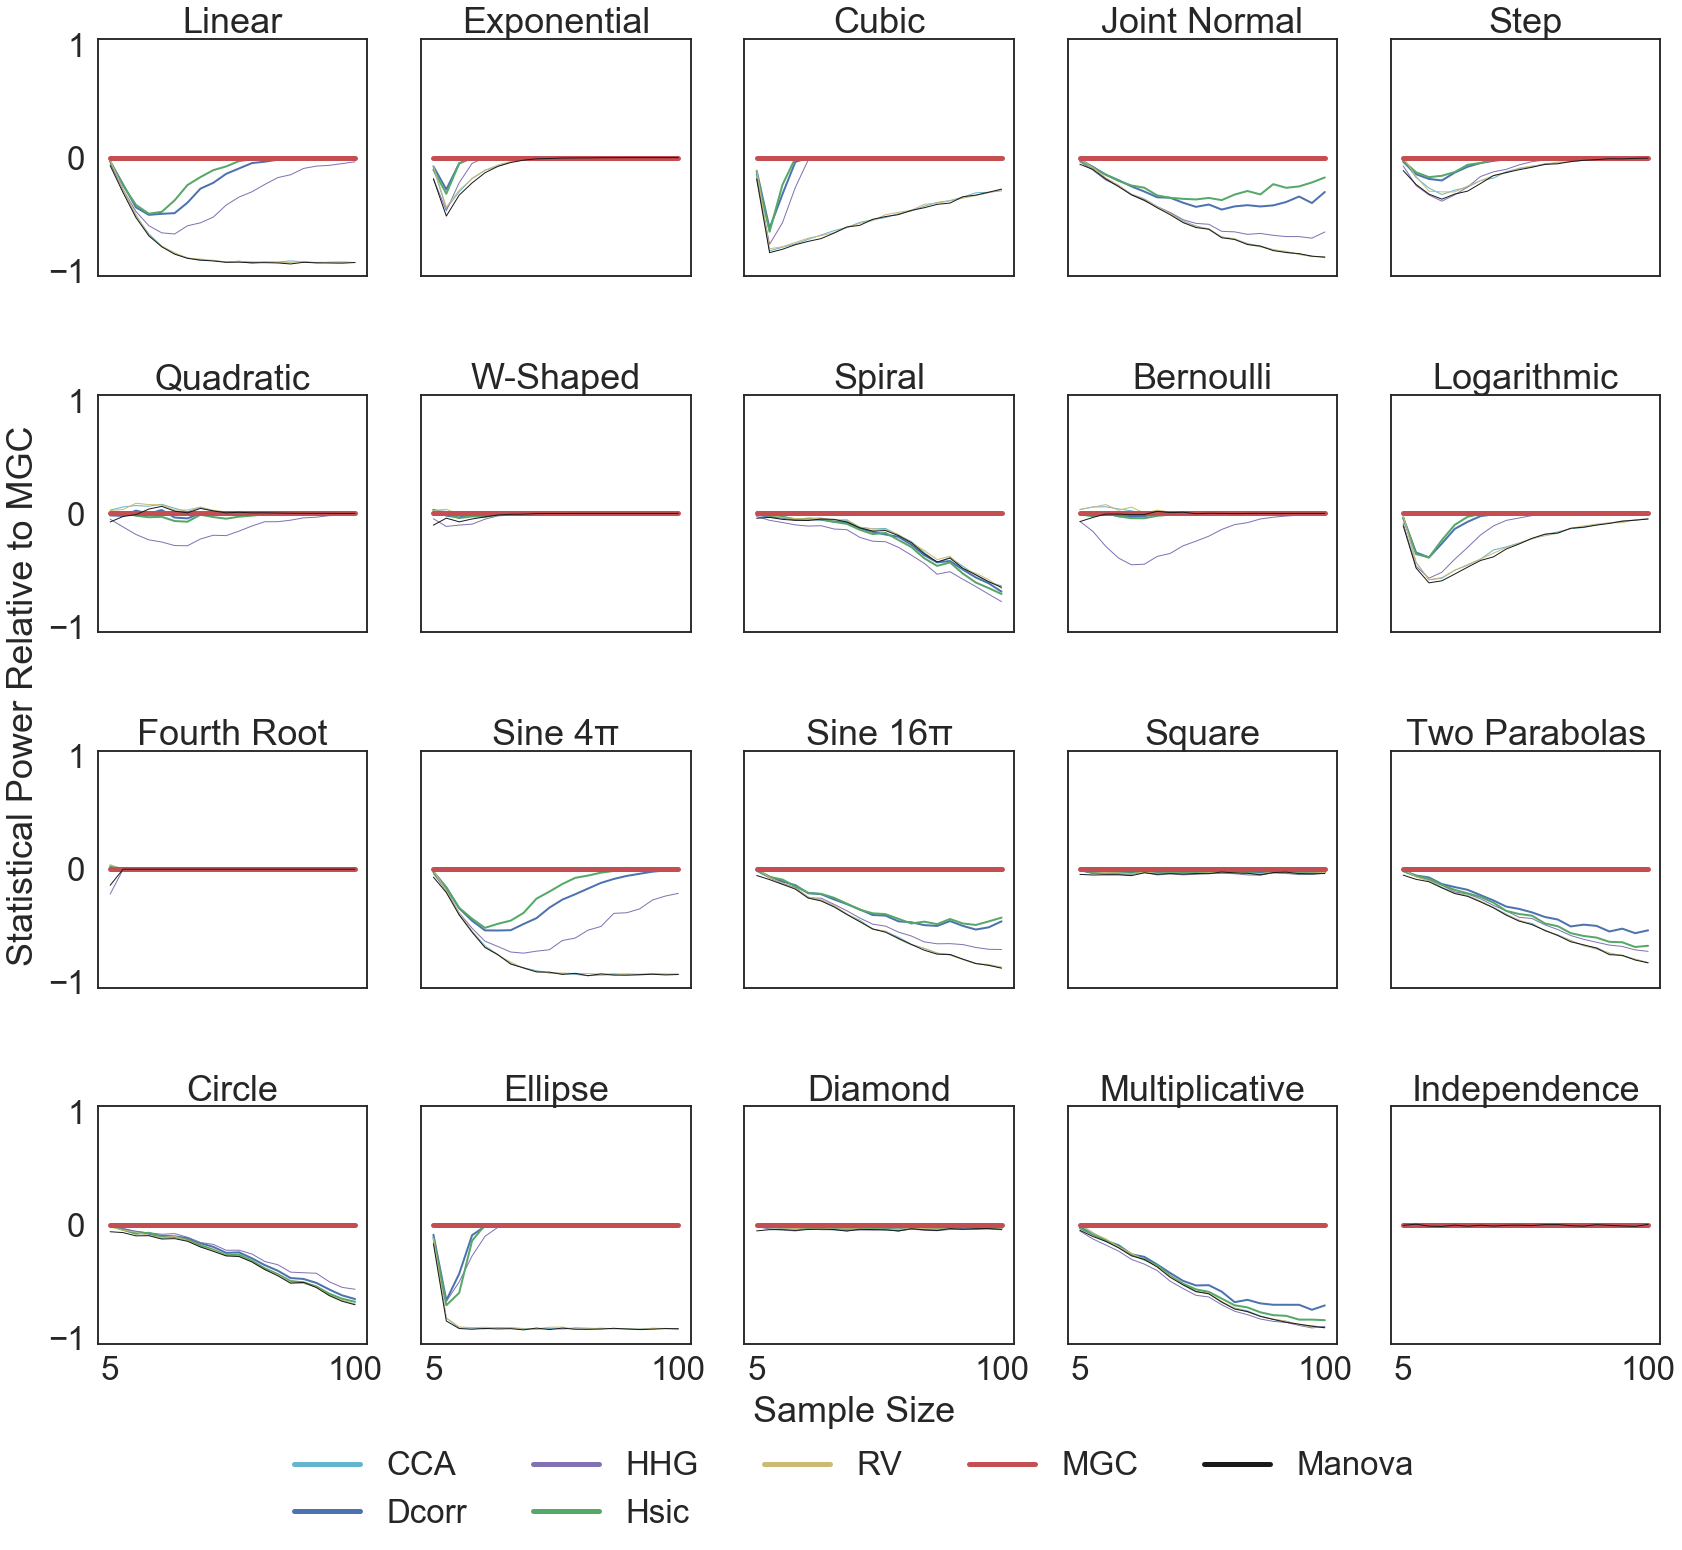

In [7]:
plot_power()